In [44]:
import pandas as pd
import nltk
import numpy as np
from gensim.models import Word2Vec
from os import listdir
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import gensim
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras import preprocessing
from keras.preprocessing import sequence
import keras
from sklearn import metrics

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
docs = pd.read_csv('/content/drive/MyDrive/data_cleaned_1.csv')

In [ ]:
docs = docs.dropna()

In [ ]:
docs['dialect_cat'] = docs['dialect'].factorize()[0]

In [ ]:
docs = docs.sample(frac=1)

In [ ]:
docs

,id,text,dialect,dialect_cat
212815,1166778690304389120,المدرب وش تبيه يسوي الموجود الكلام يوجه لسويكت...,SA,8
168665,597082876010631168,خذلك هاله خصاونة تو 2,JO,6
161269,1165683212577857536,مصبرني هاليوم الا طنجرة الملفوف اللي عالغاز pe...,JO,6
336976,1137809202372648960,سهم يلي يبي انا حاضر,KW,13
73866,1171559734429790208,طيب واذا طلع يافعي وش المطلوب منا نسويلك مثلآ ...,QA,2
...,...,...,...,...
18037,1000471626285232000,شوفه النت المسلسل فضيع يستاهل,LY,1
238220,1181190880318951424,ااااه اوكي انا نحب بقلبي برك,DZ,10
421671,998083898297942016,حالج حالي حشرونا,AE,16
450756,1003930680097681408,اللي ينقال الحظ الحلو,BH,17


In [ ]:
docs.isnull().sum().max()

0

In [ ]:
docs['text'] = docs['text'].astype(str)
docs['dialect'] = docs['dialect'].astype(str)

In [71]:
X_train, X_test, y_train, y_test = train_test_split(docs['text'].values,docs['dialect_cat'].values, test_size=0.25,random_state=1,stratify = docs['dialect_cat'])

## Preparing the data for DeepLearning Embedding layer

In [ ]:
from keras.preprocessing import text
TOP_K = 50000

MAX_SEQUENCE_LENGTH = 100

def sequence_vectorize(train_texts, val_texts):

    #Tokenizing the dataset with a max word count of Top_K
    tokenizer = text.Tokenizer(num_words=TOP_K)
    tokenizer.fit_on_texts(train_texts)

    # Vectorize training and validation texts.
    x_train = tokenizer.texts_to_sequences(train_texts)
    x_val = tokenizer.texts_to_sequences(val_texts)
    
    #padding the training and validation text so they be same length
    x_train = sequence.pad_sequences(x_train,padding='post' ,maxlen=MAX_SEQUENCE_LENGTH)
    x_val = sequence.pad_sequences(x_val,padding='post', maxlen=MAX_SEQUENCE_LENGTH)
    return x_train, x_val, tokenizer.word_index

In [ ]:
x_train,x_val,word_index = sequence_vectorize(X_train,X_test)

In [ ]:
#Converting labels
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
vocabsize = len(word_index) +1

## CNN & LSTM Model Training

In [ ]:
model_2 = Sequential()
model_2.add(Embedding(vocabsize, 64, input_length=MAX_SEQUENCE_LENGTH))
model_2.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model_2.add(Dropout(0.2))
model_2.add(MaxPooling1D(pool_size=2))
model_2.add(LSTM(100))
model_2.add(Dropout(0.2))
model_2.add(Dense(18, activation='softmax'))
model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_2.summary())

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 100, 64)           27992704  
                                                                 
 conv1d_17 (Conv1D)          (None, 100, 32)           6176      
                                                                 
 dropout_4 (Dropout)         (None, 100, 32)           0         
                                                                 
 max_pooling1d_15 (MaxPoolin  (None, 50, 32)           0         
 g1D)                                                            
                                                                 
 lstm_8 (LSTM)               (None, 100)               53200     
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                     

In [ ]:
filepath="/content/drive/MyDrive"
callback_list = [(ModelCheckpoint(filepath,patience=3, monitor='val_acc', verbose=1, save_best_only=True, mode='max',save_weights_only=True)),
              keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=2)]
history = model_2.fit(x_train, y_train, validation_data=(x_val, y_test), epochs=25, batch_size=512, verbose=1,callbacks=callback_list)

Epoch 1/25
671/671 [==============================] - 43s 60ms/step - loss: 2.5803 - accuracy: 0.1779 - val_loss: 2.2495 - val_accuracy: 0.2682
Epoch 2/25
671/671 [==============================] - 40s 59ms/step - loss: 2.0476 - accuracy: 0.3219 - val_loss: 1.9473 - val_accuracy: 0.3602
Epoch 3/25
671/671 [==============================] - 40s 60ms/step - loss: 1.7705 - accuracy: 0.4110 - val_loss: 1.8455 - val_accuracy: 0.4023
Epoch 4/25
671/671 [==============================] - 40s 59ms/step - loss: 1.5870 - accuracy: 0.4789 - val_loss: 1.8159 - val_accuracy: 0.4278
Epoch 5/25
671/671 [==============================] - 40s 60ms/step - loss: 1.4413 - accuracy: 0.5324 - val_loss: 1.8199 - val_accuracy: 0.4400
Epoch 6/25
671/671 [==============================] - 40s 59ms/step - loss: 1.3213 - accuracy: 0.5762 - val_loss: 1.8465 - val_accuracy: 0.4436
Epoch 7/25
671/671 [==============================] - 39s 59ms/step - loss: 1.2230 - accuracy: 0.6104 - val_loss: 1.8643 - val_accuracy:

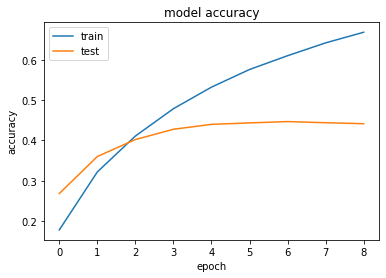

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

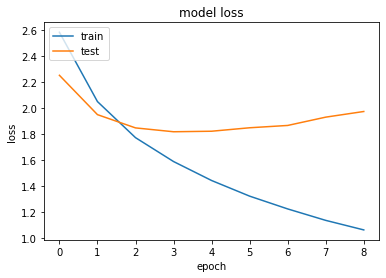

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## CNN Model Training

In [ ]:
model = Sequential()
model.add(Embedding(vocabsize, 64, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(32, 3, padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(18, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 64)           28039936  
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 32)           6176      
                                                                 
 dropout_2 (Dropout)         (None, 100, 32)           0         
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 50, 32)           0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                                 
 dense_2 (Dense)             (None, 250)               400250    
                                                      

In [ ]:
callbacks_list = [keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=2,),
                 keras.callbacks.ModelCheckpoint(filepath="checkpoint_path.keras",monitor="val_loss",save_best_only=True,)]

history2 = model.fit(x_train, y_train, validation_data=(x_val, y_test), epochs=5, batch_size=512, verbose=1,callbacks=callbacks_list)

Epoch 1/5
671/671 [==============================] - 284s 421ms/step - loss: 2.1159 - accuracy: 0.3233 - val_loss: 1.7773 - val_accuracy: 0.4335
Epoch 2/5
671/671 [==============================] - 279s 416ms/step - loss: 1.5993 - accuracy: 0.4913 - val_loss: 1.6572 - val_accuracy: 0.4805
Epoch 3/5
671/671 [==============================] - 286s 427ms/step - loss: 1.3832 - accuracy: 0.5606 - val_loss: 1.6420 - val_accuracy: 0.4885
Epoch 4/5
671/671 [==============================] - 281s 419ms/step - loss: 1.2180 - accuracy: 0.6135 - val_loss: 1.6727 - val_accuracy: 0.4905
Epoch 5/5
671/671 [==============================] - ETA: 0s - loss: 1.0716 - accuracy: 0.6587

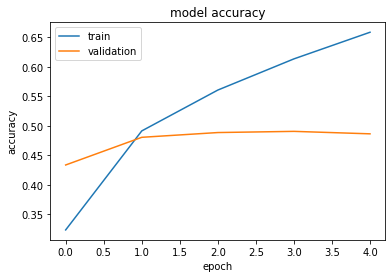

In [45]:
import matplotlib.pyplot as plt
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

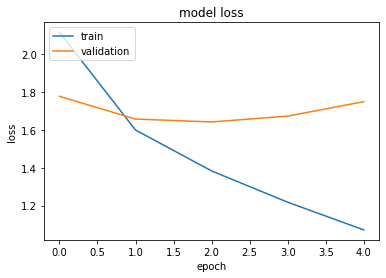

In [47]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [61]:
from sklearn.metrics import classification_report
y_pred = np.argmax(model.predict(x_val, batch_size=64, verbose=1),axis=1)


print(y_pred)

1789/1789 [==============================] - 20s 11ms/step
[ 2 11 12 ... 16 17 11]


In [70]:
y_test[2]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0.], dtype=float32)

In [72]:
print(metrics.classification_report(y_test, y_pred, target_names= docs['dialect'].unique()))

              precision    recall  f1-score   support

          SA       0.54      0.47      0.50      3874
          JO       0.57      0.63      0.60      9124
          KW       0.44      0.42      0.43      7767
          QA       0.45      0.48      0.47     10935
          MA       0.42      0.26      0.32      4060
          TN       0.56      0.40      0.47      2311
          DZ       0.38      0.31      0.34      6980
          OM       0.64      0.51      0.57      2884
          BH       0.32      0.44      0.37      6707
          EG       0.34      0.13      0.18      2481
          SD       0.58      0.48      0.53      4045
          PL       0.67      0.81      0.74     14409
          LB       0.53      0.64      0.58      6904
          LY       0.45      0.51      0.48     10527
          AE       0.28      0.30      0.29      4778
          SY       0.60      0.49      0.54      3608
          IQ       0.38      0.37      0.38      6574
          YE       0.36    

In [ ]:
history2.model.save("LSTM_CNN_Model.h5")